In [5]:
import argparse
import os
import shutil

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

from dpp_nets.utils.io import make_embd, make_tensor_dataset
from dpp_nets.layers.layers import DeepSetBaseline

parser = argparse.ArgumentParser(description='Baseline (Deep Sets) Trainer')

parser.add_argument('-a', '--aspect', type=str, choices=['aspect1', 'aspect2', 'aspect3', 'all'],
                    help='what is the target?', required=True)
parser.add_argument('--remote', type=int,
                    help='training locally or on cluster?', required=True)

parser.add_argument('--data_path_local', type=str, default='/Users/Max/data/beer_reviews',
                    help='where is the data folder locally?')
parser.add_argument('--data_path_remote', type=str, default='/cluster/home/paulusm/data/beer_reviews',
                    help='where is the data folder?')

parser.add_argument('--ckp_path_local', type=str, default='/Users/Max/checkpoints/beer_reviews',
                    help='where is the data folder locally?')

parser.add_argument('--ckp_path_remote', type=str, default='/cluster/home/paulusm/checkpoints/beer_reviews',
                    help='where is the data folder?')

parser.add_argument('-b', '--batch-size', default=50, type=int,
                    metavar='N', help='mini-batch size (default: 50)')
parser.add_argument('--epochs', default=100, type=int, metavar='N',
                    help='number of total epochs to run')
#parser.add_argument('--lr-k', '--learning-rate-k', default=0.1, type=float,
#                    metavar='LRk', help='initial learning rate for kernel net')
#parser.add_argument('--lr-p', '--learning-rate-p', default=0.1, type=float,
#                    metavar='LRp', help='initial learning rate for pred net')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate for baseline')
#parser.add_argument('--reg', type=float, required=True,
#                    metavar='reg', help='regularization constant')
#parser.add_argument('--reg-mean', type=float, required=True,
#                    metavar='reg_mean', help='regularization_mean')

def main():

    global args, lowest_loss

    args = parser.parse_args()
    lowest_loss = 100 # arbitrary high number as upper bound for loss

    ### Load data
    if args.remote:
        # print('training remotely')
        train_path = os.path.join(args.data_path_remote, str.join(".",['reviews', args.aspect, 'train.txt.gz']))
        val_path   = os.path.join(args.data_path_remote, str.join(".",['reviews', args.aspect, 'heldout.txt.gz']))
        embd_path = os.path.join(args.data_path_remote, 'review+wiki.filtered.200.txt.gz')

    else:
        # print('training locally')
        train_path = os.path.join(args.data_path_local, str.join(".",['reviews', args.aspect, 'train.txt.gz']))
        val_path   = os.path.join(args.data_path_local, str.join(".",['reviews', args.aspect, 'heldout.txt.gz']))
        embd_path = os.path.join(args.data_path_local, 'review+wiki.filtered.200.txt.gz')

    embd, word_to_ix = make_embd(embd_path)
    train_set = make_tensor_dataset(train_path, word_to_ix)
    val_set = make_tensor_dataset(val_path, word_to_ix)
    print("loaded data")

    torch.manual_seed(0)
    train_loader = DataLoader(train_set, args.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, args.batch_size)
    print("loader defined")

    ### Build model
    # Network parameters
    embd_dim = embd.weight.size(1)
    hidden_dim = 500
    enc_dim = 200
    if args.aspect == 'all':
        target_dim = 3
    else: 
        target_dim = 1

    # Model
    torch.manual_seed(0)
    trainer = MarginalTrainer(embd, hidden_dim, kernel_dim, enc_dim, target_dim)
    trainer.activation = nn.Sigmoid()
    trainer.reg = args.reg
    trainer.reg_mean = args.reg_mean
    print("created trainer")

    # Set-up Training
    params = [{'params': trainer.kernel_net.parameters(), 'lr': args.lr_k},
              {'params': trainer.pred_net.parameters(),   'lr': args.lr_p}]
    optimizer = torch.optim.Adam(params)
    print('set-up optimizer')

    ### Loop
    torch.manual_seed(0)
    print("started loop")
    for epoch in range(args.epochs):

        adjust_learning_rate(optimizer, epoch)

        train(train_loader, trainer, optimizer)        
        loss, pred_loss, reg_loss = validate(val_loader, trainer)
        
        log(epoch, loss, pred_loss, reg_loss)
        print("logged")

        is_best = pred_loss < lowest_loss
        lowest_loss = min(pred_loss, lowest_loss)    
        save = {'epoch:': epoch + 1, 
                'model': 'Marginal Trainer',
                'state_dict': trainer.state_dict(),
                'lowest_loss': lowest_loss,
                'optimizer': optimizer.state_dict()} 

        save_checkpoint(save, is_best)
        print("saved a checkpoint")

    print('*'*20, 'SUCCESS','*'*20)


def train(loader, model, criterion, optimizer):

    model.train()

    for t, (review, target) in enumerate(loader):
        review = Variable(review)

        if args.aspect == 'all':
            target = Variable(target[:,:3])
        else:
            target = Variable(target[:,int(args.aspect[-1])])

        pred = model(review)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("trained one batch")

def validate(loader, model, criterion):

    model.eval()

    total_loss = 0.0

    for i, (review, target) in enumerate(loader, 1):

        review = Variable(review, volatile=True)

        if args.aspect == 'all':
            target = Variable(target[:,:3], volatile=True)
        else:
            target = Variable(target[:,int(args.aspect[-1])], volatile=True)

        pred = model(review)
        loss = criterion(pred, target)
        
        delta = loss.data[0] - total_loss
        total_loss += (delta / i)

        print("validated one batch")

    return total_loss

def log(epoch, loss):
    string = str.join(" | ", ['Epoch: %d' % (epoch), 'Validation Loss: %.5f' % (loss)])

    if args.remote:
        destination = os.path.join(args.ckp_path_remote, args.aspect + str(args.lr) + 'baseline_log.txt')
    else:
        destination = os.path.join(args.ckp_path_local, args.aspect + str(args.lr) + 'baseline_log.txt')

    with open(destination, 'a') as log:
        log.write(string + '\n')

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR multiplied by factor 0.1 for every 20 epochs"""
    lr = args.lr * (0.1 ** (epoch // 25))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def save_checkpoint(state, is_best, filename='baseline_checkpoint.pth.tar'):
    """
    State is a dictionary that cotains valuable information to be saved.
    """
    if args.remote:
        destination = os.path.join(args.ckp_path_remote, args.aspect + str(args.lr) + filename)
    else:
        destination = os.path.join(args.ckp_path_local, args.aspect + str(args.lr) + filename)
    
    torch.save(state, destination)
    if is_best:
        if args.remote:
            best_destination = os.path.join(args.ckp_path_remote, args.aspect + str(args.lr) + 'baseline_model_best.pth.tar')
        else:
            best_destination = os.path.join(args.ckp_path_local, args.aspect + str(args.lr) + 'baseline_model_best.pth.tar')
        
        shutil.copyfile(destination, best_destination)

In [6]:
args = parser.parse_args("-a all --remote 0".split())

In [7]:
val_path   = os.path.join(args.data_path_local, str.join(".",['reviews', args.aspect, 'heldout.txt.gz']))
embd_path = os.path.join(args.data_path_local, 'review+wiki.filtered.200.txt.gz')
embd, word_to_ix = make_embd(embd_path)
val_set = make_tensor_dataset(val_path, word_to_ix)
val_loader = DataLoader(val_set, 10000)

In [285]:
# Load model
from dpp_nets.layers.layers import MarginalTrainer, ReinforceSampler

load_path = '/Users/Max/checkpoints/full_backups/no_batch_normalization_elu/'
model_name = 'allreg0.1reg_mean10.0marginal_checkpoint.pth.tar'
a_dict = torch.load(os.path.join(load_path, model_name))
reinstated_model = MarginalTrainer(embd, 200,500,200,3)
#reinstated_model.load_state_dict(a_dict['state_dict'])
for param_name, params in a_dict['state_dict'].items():
    if '.0.' in param_name or '.2.' in param_name or '.4.' in param_name:
        pass
    else:
        exec(str('reinstated_model.'+str(param_name)+' = nn.Parameter(params)'))
reinstated_model.activation = nn.Sigmoid()
reinstated_model.reg = 0.1
reinstated_model.reg_mean = 10
ix_to_word = {}
for k, v in word_to_ix.items():
    ix_to_word[v + 1] = k

In [313]:
import random

ix = random.randint(0,10000)
review, target = val_set[ix]
sampler = ReinforceSampler(1)
print(target.numpy()[:3])

[ 0.80000001  1.          0.60000002]


In [314]:
words = reinstated_model.embd(Variable(review.unsqueeze(0), volatile=True))
kernel, words = reinstated_model.kernel_net(words)
sampler.s_ix = reinstated_model.kernel_net.s_ix
sampler.e_ix = reinstated_model.kernel_net.e_ix
sampler(kernel, words) 

my_sample = sampler.saved_subsets[0][0]
cut_review = review[:my_sample.size(0)]

my_list = list(cut_review.masked_select(my_sample.data.byte()))
original_review = [ix_to_word[i] for i in list(cut_review)]
print(" ".join(original_review))
print(50*'_')
for i in my_list:
    print(ix_to_word[i])

a - black with a huge coffee colored head s - smells delicious - very sweet , chocolate malts . there is a nice balance of roasted malts as well . the most balanced smell to a stout i have had the pleasure of knowing . t - the taste is great . this is pretty sweet upfront ; some chocolate and caramel malts first . next , i was hit with roasted malts , and some booze on the finish . m - thin and leaves a cough syrup-like coating . the booze is decently hidden . d - this is a pretty fantastic stout . i am glad this recently came to missouri because i am going to be buying this frequently .
__________________________________________________
upfront
hit
roasted
and
cough
coating
.
fantastic
am
frequently


In [316]:
from dpp_nets.my_torch.linalg import custom_decomp, custom_inverse 

# compute marginals
V = kernel
word = words
# compute marginal kernel K
#vals, vecs = custom_decomp()(V)
#K = vecs.mm((1 / (vals + 1)).diag()).mm(vecs.t()) # actually K = (identity - expression) 
#marginals = (1 - K.diag()).diag() ## need to rewrite custom_decomp to return full svd + correct gradients. 
# so this is the inefficient way
identity = Variable(torch.eye(word.size(0)).type(words.data.type()))
L = V.mm(V.t())
K = identity - custom_inverse()(L + identity)
marginals = (K.diag()).data.numpy()

# display highest marginals
import numpy
sort = numpy.argsort(-marginals)
top_k = 25
for pos in sort[:top_k]:
    word_ix = cut_review[pos]
    word = ix_to_word[word_ix]
    print(word, marginals[pos])

cough 0.476442
thin 0.374656
fantastic 0.360794
syrup-like 0.268623
smells 0.249733
pleasure 0.231154
coffee 0.230662
colored 0.225538
coating 0.201477
delicious 0.198955
hit 0.191508
black 0.187336
sweet 0.182698
sweet 0.182097
most 0.168271
great 0.162074
hidden 0.150951
chocolate 0.149154
chocolate 0.148343
well 0.142472
huge 0.139779
decently 0.13935
m 0.128996
head 0.113586
finish 0.113375


In [318]:
from sklearn.decomposition import PCA

In [322]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  


[ 0.99244289  0.00755711]


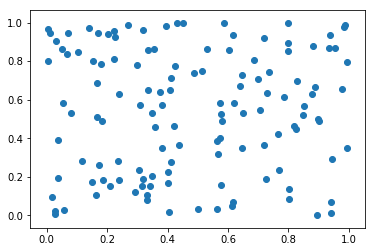

In [367]:
N = 128
x = np.random.rand(N)
y = np.random.rand(N)
plt.scatter(x, y)
plt.show()

In [358]:
# sobol sequence
from SALib.sample import sobol_sequence

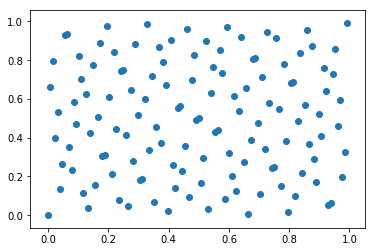

In [368]:
sobol = sobol_sequence.sample(N,2)
x = sobol[:,0]
y = sobol[:,1]
plt.scatter(x, y)
plt.show()

In [399]:
N = 128
D = 10000
X = np.random.rand(D, N)
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

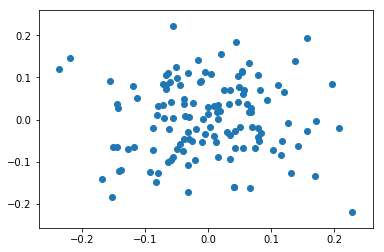

In [400]:
x = pca.components_[0,:]
y = pca.components_[1,:]
plt.scatter(x, y)
plt.show()

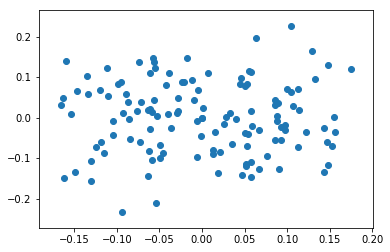

In [389]:
# sobol sequence
sobol = sobol_sequence.sample(N,D)
pca_sobol = PCA(n_components=2)
pca_sobol.fit(sobol.T)
x = pca_sobol.components_[0,:]
y = pca_sobol.components_[1,:]
plt.scatter(x, y)
plt.show()

In [ ]:
def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)

NameError: name 'rnn' is not defined

In [4]:
import spacy
from nltk import Tree


en_nlp = spacy.load('en')

doc = en_nlp("The quick brown fox jumps over the lazy dog.")

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_


[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

                jumps                  
  ________________|____________         
 |    |     |     |    |      over     
 |    |     |     |    |       |        
 |    |     |     |    |      dog      
 |    |     |     |    |    ___|____    
The quick brown  fox   .  the      lazy



[None]

In [20]:
import random

from dpp_nets.utils.language import BeerDataset, process_batch
from torch.utils.data import DataLoader
from dpp_nets.utils.language import create_clean_vocabulary

train_path   = os.path.join(args.data_path_local, str.join(".",['reviews', args.aspect, 'train.txt.gz']))
nlp, vocab, embd = create_clean_vocabulary(embd_path, train_path)
ds = BeerDataset(val_path)
ix = random.randint(1,100)
review = ds[ix]['review']

In [17]:
doc = nlp(review)

NameError: name 'nlp' is not defined

In [21]:
nlp, vocab, embd = create_clean_vocabulary(embd_path, train_path)

